# Few shot leanring

Here, it is the network through which our two images (one reference image and the
query image) pass. Let's understand the working details of Siamese networks and
how they help in identifying images of the same person with only a few images. First,
let's go through the high-level overview of how Siamese networks work:

![Siamese network](../imgs/other1.png)

We go through the following steps:
1. Pass an image through a convolution network.

2. Pass another image through the same neural network as in step 1.

3. Calculate the encodings (features) of both images.

4. Calculate the difference between the two feature vectors.

5. Pass the difference vector through sigmoid activation, which represents
whether the two images are similar.


The word Siamese in the preceding architecture relates to passing two images
through a twin network (where we duplicate the network to handle two images) to
fetch image encodings of each of the two images. Further, we are comparing the
encodings of two images to fetch a similarity score for the two images. If the
similarity score (or dissimilarity score) is beyond a threshold, we consider the images
to be of the same person.

The high-level strategy that we adopt is the following:

1. Fetch the dataset.

2. Create data in such a way that the dissimilarity of two images of the same
person will be low and dissimilarity is high when two images are of
different persons.

3. Build a convolutional neural network (CNN).

4. We expect the CNN to sum the loss values both corresponding to the
classification loss if the images are of the same person, and the distance
between the two images. We use contrastive loss for this exercise.

5. Train the model over increasing epochs.

In [1]:
!pip install -q torch_snippets
from torch_snippets import *
!wget -q https://www.dropbox.com/s/ua1rr8btkmpqjxh/face-detection.zip
!unzip -q face-detection.zip
device = 'cuda' if torch.cuda.is_available() else 'cpu'

/home/lacie/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class SiameseNetworkDataset(Dataset):
    def __init__(self, folder, transform=None, should_invert=True):
        self.folder = folder
        self.items = Glob(f'{self.folder}/*/*') 
        self.transform = transform
    def __getitem__(self, ix):
        itemA = self.items[ix]
        person = fname(parent(itemA))
        same_person = randint(2)
        if same_person:
            itemB = choose(Glob(f'{self.folder}/{person}/*', silent=True))
        else:
            while True:
                itemB = choose(self.items)
                if person != fname(parent(itemB)):
                    break
        imgA = read(itemA)
        imgB = read(itemB)
        if self.transform:
            imgA = self.transform(imgA)
            imgB = self.transform(imgB)
        return imgA, imgB, np.array([1-same_person])
    def __len__(self):
        return len(self.items)


In [3]:
from torchvision import transforms

trn_tfms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(5, (0.01,0.2),
                            scale=(0.9,1.1)),
    transforms.Resize((100,100)),
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))
])

val_tfms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((100,100)),
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))
])

trn_ds = SiameseNetworkDataset(folder="./data/faces/training/", transform=trn_tfms)
val_ds = SiameseNetworkDataset(folder="./data/faces/testing/", transform=val_tfms)

trn_dl = DataLoader(trn_ds, shuffle=True, batch_size=64)
val_dl = DataLoader(val_ds, shuffle=False, batch_size=64)

In [4]:
def convBlock(ni, no):
    return nn.Sequential(
        nn.Dropout(0.2),
        nn.Conv2d(ni, no, kernel_size=3, padding=1, padding_mode='reflect'),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(no),
    )

In [5]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.features = nn.Sequential(
            convBlock(1,4),
            convBlock(4,8),
            convBlock(8,8),
            nn.Flatten(),
            nn.Linear(8*100*100, 500), nn.ReLU(inplace=True),
            nn.Linear(500, 500), nn.ReLU(inplace=True),
            nn.Linear(500, 5)
        )

    def forward(self, input1, input2):
        output1 = self.features(input1)
        output2 = self.features(input2)
        return output1, output2

In [6]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        acc = ((euclidean_distance > 0.6) == label).float().mean()
        return loss_contrastive, acc

In [7]:
def train_batch(model, data, optimizer, criterion):
    imgsA, imgsB, labels = [t.to(device) for t in data]
    optimizer.zero_grad()
    codesA, codesB = model(imgsA, imgsB)
    loss, acc = criterion(codesA, codesB, labels)
    loss.backward()
    optimizer.step()
    return loss.item(), acc.item()

@torch.no_grad()
def validate_batch(model, data, criterion):
    imgsA, imgsB, labels = [t.to(device) for t in data]
    codesA, codesB = model(imgsA, imgsB)
    loss, acc = criterion(codesA, codesB, labels)
    return loss.item(), acc.item()

In [8]:
model = SiameseNetwork().to(device)
criterion = ContrastiveLoss()
optimizer = optim.Adam(model.parameters(),lr = 0.001)

In [9]:
n_epochs = 200
log = Report(n_epochs)

for epoch in range(n_epochs):
    N = len(trn_dl)
    for i, data in enumerate(trn_dl):
        loss, acc = train_batch(model, data, optimizer, criterion)
        log.record(epoch+(1+i)/N, trn_loss=loss, trn_acc=acc, end='\r')
    N = len(val_dl)
    for i, data in enumerate(val_dl):
        loss, acc = validate_batch(model, data, criterion)
        log.record(epoch+(1+i)/N, val_loss=loss, val_acc=acc, end='\r')
    if (epoch+1)%20==0: log.report_avgs(epoch+1)
    if epoch==10: optimizer = optim.Adam(model.parameters(), lr=0.0005)

EPOCH: 20.000  val_acc: 0.633  trn_loss: 0.665  val_loss: 0.647  trn_acc: 0.633  (11.66s - 104.98s remaining)
EPOCH: 40.000  val_acc: 0.900  trn_loss: 0.474  val_loss: 0.266  trn_acc: 0.732  (21.18s - 84.71s remaining)
EPOCH: 60.000  val_acc: 0.900  trn_loss: 0.397  val_loss: 0.129  trn_acc: 0.769  (30.68s - 71.60s remaining)
EPOCH: 80.000  val_acc: 0.833  trn_loss: 0.335  val_loss: 0.222  trn_acc: 0.786  (40.42s - 60.62s remaining)
EPOCH: 100.000  val_acc: 0.833  trn_loss: 0.257  val_loss: 0.161  trn_acc: 0.848  (50.19s - 50.19s remaining)
EPOCH: 120.000  val_acc: 1.000  trn_loss: 0.305  val_loss: 0.042  trn_acc: 0.854  (60.14s - 40.10s remaining)
EPOCH: 140.000  val_acc: 0.833  trn_loss: 0.237  val_loss: 0.171  trn_acc: 0.891  (70.06s - 30.02s remaining)
EPOCH: 160.000  val_acc: 0.867  trn_loss: 0.209  val_loss: 0.155  trn_acc: 0.889  (79.62s - 19.91s remaining)
EPOCH: 180.000  val_acc: 0.900  trn_loss: 0.209  val_loss: 0.108  trn_acc: 0.907  (89.45s - 9.94s remaining)
EPOCH: 200.000

100%|██████████| 301/301 [00:00<00:00, 11703.77it/s]


[08/15/23 20:28:41] INFO     metric val_loss was not fully recorded. ]8;id=176789;file:///home/lacie/miniconda3/envs/conda-pytorch/lib/python3.8/site-packages/torch_snippets/torch_loader.py\torch_loader.py]8;;\:]8;id=445924;file:///home/lacie/miniconda3/envs/conda-pytorch/lib/python3.8/site-packages/torch_snippets/torch_loader.py#plot_epochs:235\plot_epochs:235]8;;\
                             Plotting final epochs using last                                       
                             recorded value                                                         

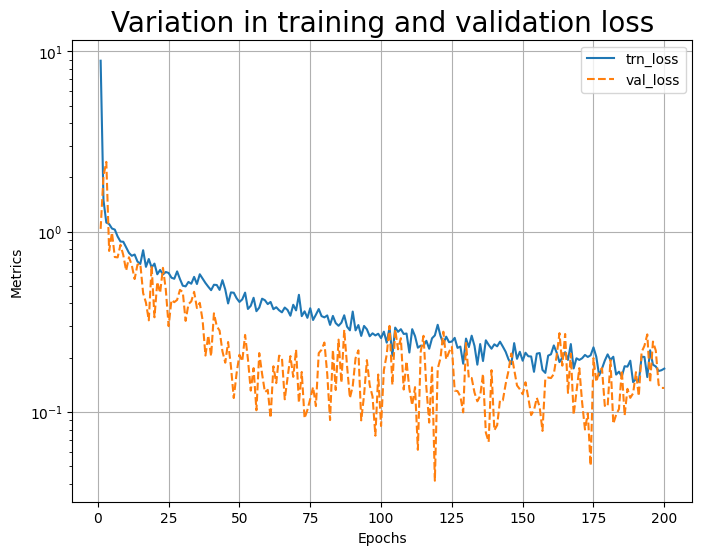

100%|██████████| 301/301 [00:00<00:00, 13181.10it/s]


                    INFO     metric val_acc was not fully recorded.  ]8;id=886215;file:///home/lacie/miniconda3/envs/conda-pytorch/lib/python3.8/site-packages/torch_snippets/torch_loader.py\torch_loader.py]8;;\:]8;id=772912;file:///home/lacie/miniconda3/envs/conda-pytorch/lib/python3.8/site-packages/torch_snippets/torch_loader.py#plot_epochs:235\plot_epochs:235]8;;\
                             Plotting final epochs using last                                       
                             recorded value                                                         

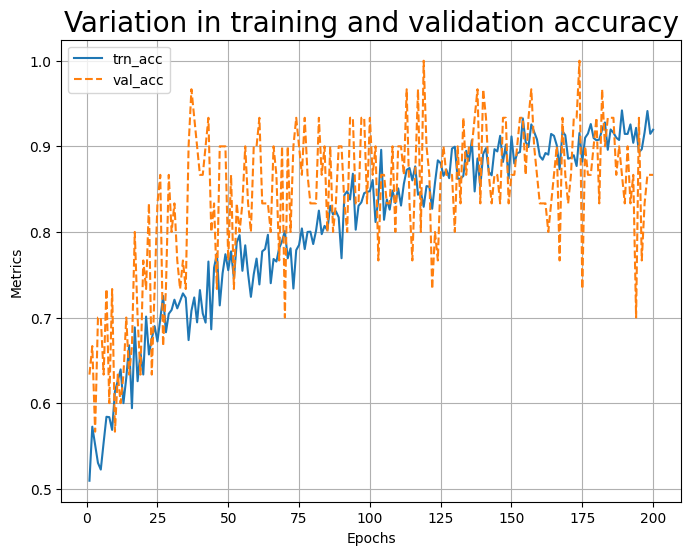

In [10]:
log.plot_epochs(['trn_loss', 'val_loss'], log=True, title='Variation in training and validation loss')
log.plot_epochs(['trn_acc', 'val_acc'], title='Variation in training and validation accuracy')

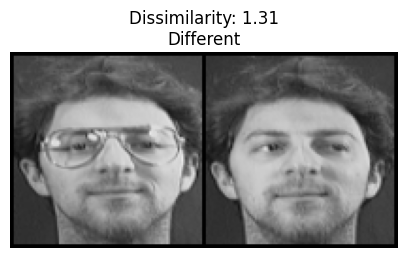

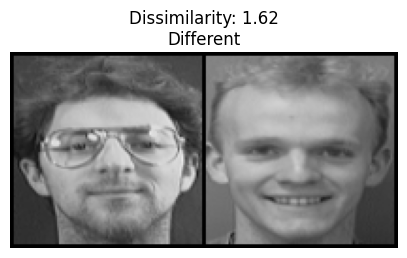

In [11]:
model.eval()
val_dl = DataLoader(val_ds,num_workers=6,batch_size=1,shuffle=True)
dataiter = iter(val_dl)
x0, _, _ = next(dataiter)

for i in range(2):
    _, x1, label2 = next(dataiter)
    concatenated = torch.cat((x0*0.5+0.5, x1*0.5+0.5),0)
    output1,output2 = model(x0.cuda(),x1.cuda())
    euclidean_distance = F.pairwise_distance(output1, output2)
    output = 'Same Face' if euclidean_distance.item() < 0.6 else 'Different'
    show(torchvision.utils.make_grid(concatenated),
         title='Dissimilarity: {:.2f}\n{}'.format(euclidean_distance.item(), output))
    plt.show()

# Prototypical networks

A prototype is the representative of a certain class. Imagine a scenario where we give
you 10 images per class and there are 5 such classes. Prototypical networks come up
with a representative embedding (a prototype) for each class by taking the average of
embeddings of each image belonging to a class.
    
Here, let's understand a practical scenario:

Imagine you have 5 distinct classes of images with the dataset containing 10 images
per class. Further, we give you 5 images per class in training and are testing your
network's accuracy on the other 5 images. We will build our network with one image
from each class and a randomly chosen test image as a query. Our task is to identify
the class of the known image (training image) that has the highest similarity with the
query image (test image).

For facial recognition, the working details of prototypical networks are as follows:

- Choose N different persons at random for training.

- Choose k samples corresponding to each person as the data points
available for training – this is our support set (images to compare).
    
- Choose q samples corresponding to each person as the data points to test –
this is our query set (images to be compared):

![image.png](../imgs/other2.png)

For now, we have chosen N c classes, with N s images in the support set and N q images
in the query set:

- Fetch the embeddings of each data point within the support set (training
images) and query set (test images) when passed through a CNN network,
where we expect the CNN network to identify the index of the training
image that has the highest similarity with the query image.

- Once you train the network, compute the prototype corresponding to the
support set (training images) embeddings:

The prototype is the mean embedding of all images
belonging to the same class:

![image.png](../imgs/other4.png)

In the preceding example illustration, there are three classes and each circle
represents the embeddings of the images belonging to the class. Each star (prototype)
is the average embedding across all the images (circles) present in the image:

Calculate the Euclidean distance between query embeddings and prototype
embeddings:

- If there are 5 query images and 10 classes, we will have 50 Euclidean
distances.

- Perform a softmax on top of the Euclidean distances obtained earlier, to
identify the probability corresponding to different support classes.

- Train a model to minimize the loss value in assigning the query image to
the right class. Further, while looping over the dataset, choose a fresh set of
persons at random in the next iteration.




# Relation networks

A relation network is fairly similar to a Siamese network, except that the metric we
optimize for is not the L1 distance between embeddings but a relation score. Let's
understand the working details of relation networks using the following diagram:



![img](../imgs/other5.png)

In the preceding diagram, the pictures on the left are the support set for five classes
and the dog image at the bottom is the query image:

- Pass both the support and query images through an embedding module,
which provides embeddings for the input image.

- Concatenate the feature maps of the support images with the feature maps
of the query image.

- Pass the concatenated features through a CNN module to predict the
relation score.

The class with the highest relation score is the predicted class of the query image.